In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

C:\Users\msubr\Anaconda3\envs\bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("UCF-crime-frames-descriptions-partitions.csv")

In [3]:
data.head(2)

,Unnamed: 0,frame,directory,class,Description,partition
0,0,Abuse001_x264.mp4_frame_000000.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train
1,1,Abuse001_x264.mp4_frame_000010.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train


In [4]:
train = data.loc[data["partition"] == "train"]
val = data.loc[data["partition"] == "validation"]
test = data.loc[data["partition"] == "test"]

In [5]:
labels = {"Normal": 0,
          "Abuse": 1,
          "Arrest": 2,
          "Arson": 3,
          "Burglary": 4,
          "Explosion": 5,
          "Fighting": 6,
          "RoadAccidents": 7,
          "Shooting": 8,
          "Vandalism": 9
         }

In [6]:
def evaluate(data):
    with torch.no_grad():
        d_pred = torch.zeros([len(data), 10])
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            batch = batch.to(device)
            pred = model(batch)
            d_pred[i:i+batch_size] = pred 
    return d_pred

In [7]:
def get_data(df):
    X = np.zeros((len(df), 1408))
    path = "d:/data/UCF-crime/Anomaly-Videos-frames-features"
    c = 0
    for _, f in df.iterrows():
        directory = f["directory"][:-7]
        X[c] = np.load(f"{path}/{directory}/{f['frame']}.npy")
        c += 1
    X = torch.tensor(X, dtype=torch.float32)
    y = list(df["class"])
    y = [labels[lbl] for lbl in y]
    y = torch.tensor(y, dtype=torch.float32)
    return X, y

In [8]:
def get_acc(pred, target, return_sum=False):
    s = (torch.argmax(pred, dim=1).round() == target).sum()
    if (return_sum == True):
        return s
    return s/len(pred)

In [9]:
def get_acc_per_lbl(pred, target, return_sum=False):
    for i in range(len(labels)):
        p = (target == i).sum()
        t = (torch.argmax(pred, dim=1) == i).sum()
        s = ((torch.argmax(pred, dim=1) == i) & (target == i)).sum()
        presc = s/t
        recall = s/p
        print(f"{i}, presc {s/t:.2f}, recall {s/p:.2f}, f1 {2*presc*recall/(presc+recall):.2f}\t total {p} {list(labels.keys())[i]}")
    
    return 

In [10]:
X = np.load("train.npy")
V = np.load("val.npy")
X = torch.tensor(X, dtype=torch.float32)
V = torch.tensor(V, dtype=torch.float32)

In [11]:
y = list(train["class"])
y = np.array([labels[lbl] for lbl in y])
y = torch.tensor(y, dtype=torch.float32)
y_val = list(val["class"])
y_val = np.array([labels[lbl] for lbl in y_val])
y_val = torch.tensor(y_val, dtype=torch.float32)

In [12]:
labels_counts = torch.tensor([(y==i).sum() for i in range(len(labels))])
weights = 1 - labels_counts / len(X)    

In [13]:
#weights = torch.tensor([0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
model = nn.Sequential(
    nn.Linear(1408, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [15]:
sum(param.numel() for param in model.parameters())

626186

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Linear(in_features=1408, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=10, bias=True)
)

In [17]:
weights = weights.to(device)
loss_fn = nn.CrossEntropyLoss(weights)  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [18]:
n_epochs = 30
batch_size = 64
for epoch in range(n_epochs):
    acc = 0
    perm = torch.randperm(len(X))
    for i in range(0, len(X), batch_size):
        Xbatch = X[perm[i:i+batch_size]]
        Xbatch = Xbatch.to(device)
        y_pred = model(Xbatch)
        ybatch = y[perm[i:i+batch_size]]
        ybatch = ybatch.type(torch.LongTensor)
        ybatch = ybatch.to(device)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc += get_acc(y_pred, ybatch, return_sum=True)
    val_pred = evaluate(V)
        
    print(f'Finished epoch {epoch}, latest loss {loss}, acc {acc/len(X)} val_acc {get_acc(val_pred, y_val)}')

Finished epoch 0, latest loss 0.6546297669410706, acc 0.7465786337852478 val_acc 0.7117951512336731
Finished epoch 1, latest loss 0.5496581196784973, acc 0.8216440677642822 val_acc 0.6885152459144592
Finished epoch 2, latest loss 0.3566860258579254, acc 0.8449474573135376 val_acc 0.6911536455154419
Finished epoch 3, latest loss 0.38056111335754395, acc 0.8608402013778687 val_acc 0.6880496740341187
Finished epoch 4, latest loss 0.4924752116203308, acc 0.8720448017120361 val_acc 0.6540092825889587
Finished epoch 5, latest loss 0.31784605979919434, acc 0.8814209699630737 val_acc 0.6647697687149048
Finished epoch 6, latest loss 0.2747323513031006, acc 0.8875911831855774 val_acc 0.6518882513046265
Finished epoch 7, latest loss 0.3803735375404358, acc 0.8940674662590027 val_acc 0.6485773324966431
Finished epoch 8, latest loss 0.16244737803936005, acc 0.8982963562011719 val_acc 0.6331091523170471
Finished epoch 9, latest loss 0.2757899761199951, acc 0.9023481011390686 val_acc 0.65250903367996

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from torch.nn.functional import one_hot

In [20]:
CLASS_LABELS = ["normal", 
                "Abuse",
                "Arrest",
                "Arson",
                "Burglary",
                "Explosion",
                "Fighting",
                "RoadAccidents",
                "Shooting",
                "Vandalism"]

def multiclass_roc_auc_score(y_true, y_pred, average="macro"):    
    fig, c_ax = plt.subplots(1,1, figsize = (8,5))
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve((y_true == idx).type(torch.int32), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    y_true = one_hot(y_true.type(torch.LongTensor))
    plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
    plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
    plt.legend(fontsize = 11.5)
    plt.show()
    return roc_auc_score(y_true, y_pred, average=average)


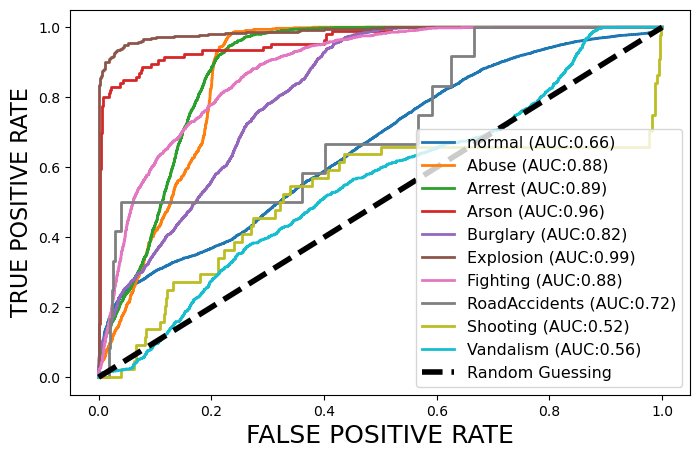

ROC AUC score: 0.786358803368438


In [21]:
print('ROC AUC score:', multiclass_roc_auc_score(y_val , val_pred, average = "macro"))

In [22]:
get_acc_per_lbl(val_pred, y_val)

0, presc 0.73, recall 0.82, f1 0.78	 total 12895 Normal
1, presc 0.21, recall 0.18, f1 0.19	 total 646 Abuse
2, presc 0.47, recall 0.10, f1 0.17	 total 1321 Arrest
3, presc 0.24, recall 0.68, f1 0.35	 total 106 Arson
4, presc 0.10, recall 0.14, f1 0.12	 total 1767 Burglary
5, presc 0.93, recall 0.54, f1 0.69	 total 388 Explosion
6, presc 0.38, recall 0.05, f1 0.08	 total 1132 Fighting
7, presc 0.00, recall 0.00, f1 nan	 total 12 RoadAccidents
8, presc 0.00, recall 0.00, f1 nan	 total 44 Shooting
9, presc 0.09, recall 0.03, f1 0.04	 total 1019 Vandalism


In [23]:
get_acc(val_pred, y_val)

tensor(0.5927)

In [24]:
X_pred = evaluate(X)

In [25]:
get_acc_per_lbl(X_pred, y)

0, presc 0.99, recall 0.94, f1 0.96	 total 84684 Normal
1, presc 0.80, recall 0.94, f1 0.87	 total 2593 Abuse
2, presc 0.96, recall 0.99, f1 0.97	 total 10454 Arrest
3, presc 0.94, recall 0.98, f1 0.96	 total 4984 Arson
4, presc 0.91, recall 0.99, f1 0.95	 total 8211 Burglary
5, presc 0.88, recall 0.95, f1 0.91	 total 2138 Explosion
6, presc 0.86, recall 0.96, f1 0.91	 total 6178 Fighting
7, presc 0.67, recall 0.78, f1 0.72	 total 689 RoadAccidents
8, presc 0.66, recall 0.89, f1 0.76	 total 1568 Shooting
9, presc 0.82, recall 0.96, f1 0.88	 total 2646 Vandalism


In [26]:
get_acc(X_pred, y)

tensor(0.9504)

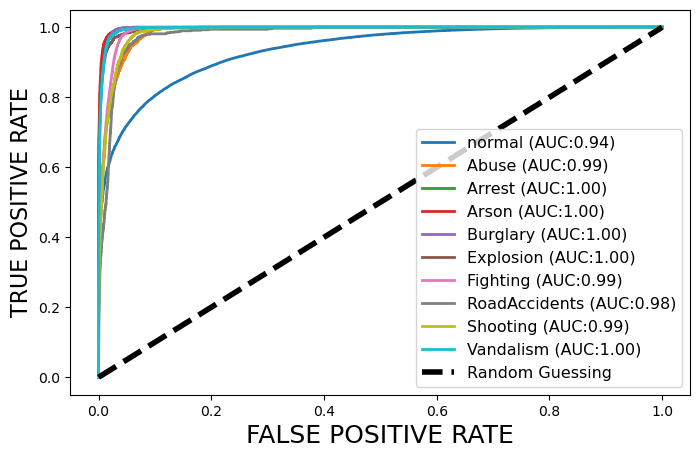

ROC AUC score: 0.986522834363746


In [27]:
print('ROC AUC score:', multiclass_roc_auc_score(y , X_pred, average = "macro"))

In [66]:
torch.save(model.state_dict(), "model_image_features.pt")